# Gdz Elektrik Datathon 2023
## A. Tuğraalp BİTİREN & Rümeysa KARA

**Major Event Day (MED.CSV):** Gün içindeki elektrik kesinti süresinin kabul edilebilir limiti aştığı gün.
Dolayısıyla kesinti olduysa o gün tahmin edilen enerjinin sapmasının yüksek olmasını bekleriz. Çünkü kesinti nedeniyle dağıtılamamış.

**Dağıtılan Enerji: Watt:** Aktif(yararlı) gücün birimi.
MWh = MegaWatt saat

- Dağıtılan Enerji'nin %85'i İzmir, %15'i ise Manisa için gerçekleştirilmektedir.

**Kullanılan Dış Kaynaklı Veriler**

**meteo (Hava Durumu Verisi):** 2018 ile 2022 yılları arasında İzmir ve Manisa il sınır koordinatları içerisinde bulunan yaklaşık 84 farklı lokasyondan ,
veriyle uyumlu ve mantıklı 4 bölgeye indirgeyerek aşağıdaki **hava durumu değişkenleri** kullanılmıstır.

NOT: **ERA5 | ECMWF ensemble modelinin verileridir.**

	- temp: Sıcaklık (Celcius),
	- dew_temp: Çiyin sıcaklığı
	- humidity: Nem
	- wspeed : Rüzgar Hızı (m/s)
	- Cloud_cover: (0-1) arasında bulutluluk oranı
    - lat 39.25 lon 27.0 : İzmir / Bergama
    - lat 38.75 lon 27.0 : İzmir / Aliağa
    - lat 38.75 lon 27.25 : Manisa / Yunusemre
    - lat 38.25 lon 27.0 : İzmir / Menderes
    
- Dew Point, çiyin oluştuğu sıcaklıktır.

- Heat Index , insan tarafından algılanan eşdeğer sıcaklığı belirleme girişiminde hava sıcaklığı ile bağıl nemi birleştiren bir indekstir.

- Feels Like (Hissedilen sıcaklık veya Görünen sıcaklık), hava sıcaklığı, bağıl nem ve rüzgar hızının birleşik etkilerinin neden olduğu, insanlar tarafından algılanan sıcaklık eşdeğeridir.

**holiday features :** Notebook içerisinde bir class oluşturularak çıkarılan Resmi/Dini/Milli/haftasonu günleri.(2018-2022)

**Modelleme Yaklaşımı:**

- Notebookta görüleceği üzere özellik mühendisliği kısmında **date componentler**, **fourier transformlar** ,**interaction özelliker**, **lag/rolling özellikler (hava durumu verileri üzerinde)**, 
**target encoding** ve **tsfresh** kütüphanesinden bir çok özellik çıkarımları uygulanmıştır.

- Catboost, Xgboost, Lightgbm ve Stack Ensemble modellemeleri denenmiştir. 

- **Hiperparametre tuning** ve manuel olarak 2019-2020-2021 ağustos aylarını içeren **Time Series cross validation** yöntemi tercih edilmiştir.

**Catboost | Public & Private Score : 2.4**


In [1]:
pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 5.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install meteocalc

  Preparing metadata (setup.py) ... done
  Created wheel for meteocalc: filename=meteocalc-1.1.0-py3-none-any.whl size=8194 sha256=db5b5827730813e7fe7532cb7f8d9d7bce3868ef94fc67740d7845e62188da67
  Stored in directory: /root/.cache/pip/wheels/51/a5/1f/dabf2254418939e221127d0fb42ebea933fcda16fc331026a0
Successfully built meteocalc
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from tsfresh.feature_extraction.feature_calculators import cid_ce, c3, benford_correlation
from feature_engine.discretisation import  EqualFrequencyDiscretiser
from dateutil.relativedelta import relativedelta
from pandas import Timestamp,to_datetime,DataFrame
from hijri_converter import Hijri, Gregorian

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import base
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

import warnings 
from meteocalc import Temp, dew_point, heat_index, wind_chill, feels_like
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor
from pathlib import Path
import optuna
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 500)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/era5-izmir-manisa/meteo.parquet
/kaggle/input/special-days/special_days.csv
/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv
/kaggle/input/gdz-elektrik-datathon-2023/med.csv
/kaggle/input/gdz-elektrik-datathon-2023/train.csv


## Feature Extraction Functions

In [4]:
def date_components(data):

    columns = "year,month,hour,weekday,week,day,dayofyear,weekofyear,quarter,dayofweek"
    for i in columns.split(","):
        data[i] = data.datetime.dt.__getattribute__(i)
    
    data['season'] = np.nan
    data.loc[data.month.isin([12,1,2]), "season"] = 1
    data.loc[data.month.isin([3,4,5]), "season"] = 2
    data.loc[data.month.isin([6,7,8]), "season"] = 3
    data.loc[data.month.isin([9,10,11]), "season"] = 4
    return data

def date_ordinals(data):
   
    data["date_day_ordinal"] = data.datetime.apply(lambda x: x.toordinal())
    return data

def shifting_features(data, collist=None, laglist=None):
    
    features = []
    for i in collist:
        colname = data[i].name
        for t in laglist:
            if t>0: #lag
                data[colname + "_lag" + str(t)] = data[colname].shift(t)
                features.append(colname + "_lag" + str(t))
            else: #lead
                data[colname + "_lead" + str(np.abs(t))] = data[colname].shift(t)
                features.append(colname + "_lead" + str(np.abs(t)))
    return data

def rolling_features(data, collist=None, rollist=None):
    
    features = []
    for i in collist:
        colname = data[i].name
        for t in rollist:

            data[[colname + str(t) + "_hrs_mean", colname + str(t) + "_hrs_median", colname + str(t) + "_hrs_std", colname + str(
                t) + "_hrs_min", colname + str(t) + "_hrs_max"]] = data[colname].rolling(t).agg([np.mean, np.median, np.std, np.min, np.max])

        features.append(colname + str(t) + "_hrs_mean")
        features.append(colname + str(t) + "_hrs_median")
        features.append(colname + str(t) + "_hrs_std")
        features.append(colname + str(t) + "_hrs_min")
        features.append(colname + str(t) + "_hrs_max")
    return data

def date_fourier_transform(data):
    
    data['sin_hour'] = np.sin(2*np.pi*data.datetime.dt.hour.values/24)
    data['cos_hour'] = np.cos(2*np.pi*data.datetime.dt.hour.values/24)
    data['sin_weekday'] = np.sin(2*np.pi*data.datetime.dt.dayofweek/7)
    data['cos_weekday'] = np.cos(2*np.pi*data.datetime.dt.dayofweek/7)
    data['sin_week'] = np.sin(2*np.pi*data.datetime.dt.week/52)
    data['cos_week'] = np.cos(2*np.pi*data.datetime.dt.week/52)
    data['sin_month'] = np.sin(2*np.pi*data.datetime.dt.month.values/12)
    data['cos_month'] = np.cos(2*np.pi*data.datetime.dt.month.values/12)
    data['sin_dayofyear'] = np.sin(2*np.pi*data.datetime.dt.day_of_year.values/365)
    data['cos_dayofyear'] = np.cos(2*np.pi*data.datetime.dt.day_of_year.values/365)
    
    return data

def daily_stats(data, cols):
   
    tmp = data.copy()
    for col in cols:
        grouped = tmp.groupby("date_day_ordinal")[col] 
        tmp[f"{col}_daily_mean"] = tmp["date_day_ordinal"].map(grouped.mean())
        tmp[f"{col}_daily_diff"] = tmp[col] - tmp["date_day_ordinal"].map(grouped.mean())
        tmp[f"{col}_daily_std"]  = tmp["date_day_ordinal"].map(grouped.std())
        tmp[f"{col}_daily_min"]  = tmp["date_day_ordinal"].map(grouped.min())
        tmp[f"{col}_daily_max"]  = tmp["date_day_ordinal"].map(grouped.max())
    return tmp

def polynomial_features(data, degree, interaction_only,  include_bias=False, featurelist=None):
   
    trans = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=include_bias)

    if len(featurelist) > 1:
        transformer = trans.fit(data[featurelist])
        data[[f"{i}" for i in transformer.get_feature_names_out()]] = transformer.fit_transform(data[featurelist])
    else:
        transformer = trans.fit(data[featurelist])
        data[[f"{i}" for i in transformer.get_feature_names_out()]] = transformer.fit_transform(data[featurelist])
    return data


In [5]:
# source : https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b#:~:text=The%20basic%20idea%20of%20the,%3D%200.6%20and%20B%3D0.3.

class KFoldTargetEncoderTrain(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, colnames,targetName,n_fold=5,verbosity=True,discardOriginal_col=False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col

    def fit(self, X, y=None):
        return self


    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = False, random_state=None)



        col_mean_name = 'target_enc' + '_' + self.colnames 
        X[col_mean_name] = np.nan

        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
#             print(tr_ind,val_ind)
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())

        X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            # print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,
            #                                                                           self.targetName,
            #                                                                           np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
            

        return X
    
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):

        mean = self.train[[self.colNames,self.encodedName]].groupby(self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]

        
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})

        return X

## Data Reading

In [6]:
df = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv')
med = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/med.csv')
sub_df = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv')

In [7]:
# external resources
meteo = pd.read_parquet('/kaggle/input/era5-izmir-manisa/meteo.parquet') # ERA5 meteoroloji verisi

# secili koordinatlar : Manisa ve İzmir merkez ve sınırlar

koordinat = ['lat39.25|lon27.0', 'lat38.75|lon27.0','lat38.75|lon27.25', 'lat38.25|lon27.0']

cols_to_filter = [col for col in meteo.columns if any(coord in col for coord in koordinat)]

meteo_ = meteo.loc[:, cols_to_filter].copy()

In [8]:
df = df.rename(columns={'Dağıtılan Enerji (MWh)':'cons','Tarih':'datetime'})
df['datetime'] = pd.to_datetime(df['datetime'])
#
med = med.rename(columns={'Tarih':'datetime'})
med['datetime'] = pd.to_datetime(med['datetime'])
#
sub_df = sub_df.rename(columns={'Dağıtılan Enerji (MWh)':'cons','Tarih':'datetime'})
sub_df['datetime'] = pd.to_datetime(sub_df['datetime'])
sub_df.loc[:,'cons'] = np.nan

In [9]:
# merging
df = pd.concat([df,sub_df])
tmp = df.merge(med, how='left', on='datetime')
# merge with weather
tmp = tmp.merge(meteo_.reset_index(), how='left', on ='datetime')

In [10]:
tmp['kesinti'] = False
for day in med.datetime.dt.date:
   
    tmp.loc[tmp.datetime.dt.date == day, 'kesinti'] = True

In [11]:
weather_cols = [
         'temp_lat39.25|lon27.0',     
         'temp_lat38.75|lon27.0',
         'temp_lat38.75|lon27.25',
         'temp_lat38.25|lon27.0',
         'dew_temp_lat39.25|lon27.0',
         'dew_temp_lat38.75|lon27.0',
         'dew_temp_lat38.75|lon27.25',
         'dew_temp_lat38.25|lon27.0',
         'wspeed_lat39.25|lon27.0',
         'wspeed_lat38.75|lon27.0',
         'wspeed_lat38.75|lon27.25',       
         'wspeed_lat38.25|lon27.0',
         'humidity_lat39.25|lon27.0',
         'humidity_lat38.75|lon27.0',
         'humidity_lat38.75|lon27.25',    
         'humidity_lat38.25|lon27.0',
         'cloud_cover_lat39.25|lon27.0',
         'cloud_cover_lat38.75|lon27.0',
         'cloud_cover_lat38.75|lon27.25',
         'cloud_cover_lat38.25|lon27.0'
    
         ]

tmp['temp_avg'] = tmp[weather_cols].filter(like='temp').mean(axis=1)
tmp['temp_max'] = tmp[weather_cols].filter(like='temp').max(axis=1)

tmp['dew_temp_avg'] = tmp[weather_cols].filter(like='dew_temp').mean(axis=1)
tmp['dew_temp_max'] = tmp[weather_cols].filter(like='dew_temp').max(axis=1)

tmp['wspeed_avg'] = tmp[weather_cols].filter(like='wspeed').mean(axis=1)
tmp['wspeed_max'] = tmp[weather_cols].filter(like='wspeed').max(axis=1)

tmp['humidity_avg'] = tmp[weather_cols].filter(like='humidity').mean(axis=1)
tmp['humidity_max'] = tmp[weather_cols].filter(like='humidity').max(axis=1)


tmp['cloud_cover_avg'] = tmp[weather_cols].filter(like='cloud_cover').mean(axis=1)

In [12]:
for col in tmp.columns:
    if col.startswith('humidity_lat'):
        tmp.loc[tmp[col] > 100, col] = 100

In [13]:
tmp['heat_index'] = tmp.apply(lambda row: heat_index(temperature=Temp(row['temp_avg'], 'c'), humidity=row['humidity_avg']).c, axis=1)
tmp['dew_point_index'] = tmp.apply(lambda row: dew_point(temperature=Temp(row['temp_avg'], 'c'), humidity=row['humidity_avg']).c, axis=1)
tmp['feels_like'] = tmp.apply(lambda row: feels_like(temperature=Temp(row['temp_avg'], 'c'), humidity=row['humidity_avg'], wind_speed=row['wspeed_avg']).c, axis=1)

In [14]:
fig =  make_subplots(specs=[[{"secondary_y": True}]])
tmp_x = tmp[(tmp.datetime.dt.year.isin([2021])) & (tmp.datetime.dt.month.isin(range(6,9)))].copy()

fig.add_trace(go.Scatter(x=tmp_x.datetime, y=tmp_x['cons'],
                        mode='lines',
                        name='tüketim',
                        line_shape='spline',
                        line=dict( width=3)),secondary_y=False) 

fig.add_trace(go.Scatter(x=tmp_x.datetime, y=tmp_x['temp_avg'],
                        mode='lines',
                        name='temp',
                        line_shape='spline',
                        line=dict( width=3)),secondary_y=True) 

fig.add_trace(go.Scatter(x=tmp_x.datetime, y=tmp_x['wspeed_avg'],
                        mode='lines',
                        name='wspeed',
                        line_shape='spline',
                        line=dict( width=3)),secondary_y=True) 

fig.add_trace(go.Scatter(x=tmp_x.datetime, y=tmp_x['humidity_avg'],
                        mode='lines',
                        name='hum',
                        line_shape='spline',
                        line=dict( width=3)),secondary_y=True) 

fig.add_trace(go.Scatter(x=tmp_x.datetime, y=tmp_x['feels_like'],
                        mode='lines',
                        name='feels_like',
                        line_shape='spline',
                        line=dict( width=3)),secondary_y=True) 




fig.show()

### Feature Extractions

In [15]:
holiday = pd.read_csv('/kaggle/input/special-days/special_days.csv')
holiday['datetime'] = pd.to_datetime(holiday['datetime'])

df_tmp = tmp.merge(holiday,how='left',on='datetime')
df_tmp = date_components(df_tmp)
df_tmp['is_month_start'] =df_tmp['datetime'].dt.is_month_start.astype(int)
df_tmp['is_month_end'] = df_tmp['datetime'].dt.is_month_end.astype(int)
df_tmp = date_ordinals(df_tmp)
df_tmp = date_fourier_transform(df_tmp)
#
f_cols = ['feels_like','temp_avg','dew_temp_avg','wspeed_avg','humidity_avg','cloud_cover_avg','temp_max','dew_temp_max','wspeed_max','humidity_max']
#
df_tmp = daily_stats(df_tmp, cols=f_cols)
df_tmp = shifting_features(df_tmp, collist= f_cols, laglist=list(range(1,4))) 
df_tmp = rolling_features(df_tmp, collist=f_cols, rollist=[3])

In [16]:
# features from tsfresh 
for day in list(df_tmp['datetime'].unique()): 
    df_tmp.loc[df_tmp['datetime'] == day, 'temp_avg_benford_day'] = benford_correlation(df_tmp.loc[df_tmp['datetime'] == day, 'temp_avg'])   
    df_tmp.loc[df_tmp['datetime'] == day, 'feels_like_benford_day'] = benford_correlation(df_tmp.loc[df_tmp['datetime'] == day, 'feels_like'])     
    df_tmp.loc[df_tmp['datetime'] == day, 'dew_temp_avg_benford_day'] = benford_correlation(df_tmp.loc[df_tmp['datetime'] == day, 'dew_temp_avg'])  
    df_tmp.loc[df_tmp['datetime'] == day, 'wspeed_avg_benford_day'] = benford_correlation(df_tmp.loc[df_tmp['datetime'] == day, 'wspeed_avg']) 
    df_tmp.loc[df_tmp['datetime'] == day, 'humidity_avg_benford_day'] = benford_correlation(df_tmp.loc[df_tmp['datetime'] == day, 'humidity_avg'])

   
for week in list(df_tmp['week'].unique()):
    df_tmp.loc[df_tmp['week'] == week, 'temp_avg_cid_ce_week'] = cid_ce(df_tmp.loc[df_tmp['week'] == week, 'temp_avg'],normalize=True)
    df_tmp.loc[df_tmp['week'] == week, 'feels_like_cid_ce_week'] = cid_ce(df_tmp.loc[df_tmp['week'] == week, 'feels_like'],normalize=True)
    df_tmp.loc[df_tmp['week'] == week, 'wspeed_avg_cid_ce_week'] = cid_ce(df_tmp.loc[df_tmp['week'] == week, 'wspeed_avg'],normalize=True)
    df_tmp.loc[df_tmp['week'] == week, 'humidity_avg_benford_week'] = benford_correlation(df_tmp.loc[df_tmp['week'] == week, 'humidity_avg'])
    df_tmp.loc[df_tmp['week'] == week, 'temp_avg_benford_week'] = benford_correlation(df_tmp.loc[df_tmp['week'] == week, 'temp_avg'])
    df_tmp.loc[df_tmp['week'] == week, 'feels_like_benford_week'] = benford_correlation(df_tmp.loc[df_tmp['week'] == week, 'feels_like'])

for month in list(df_tmp['month'].unique()):
    df_tmp.loc[df_tmp['month'] == month, 'temp_avg_cid_ce_month'] = cid_ce(df_tmp.loc[df_tmp['month'] == month, 'temp_avg'],normalize=True)
    df_tmp.loc[df_tmp['month'] == month, 'wspeed_avg_cid_ce_month'] = cid_ce(df_tmp.loc[df_tmp['month'] == month, 'wspeed_avg'],normalize=True)
    df_tmp.loc[df_tmp['month'] == month, 'humidity_avg_benford_month'] = benford_correlation(df_tmp.loc[df_tmp['month'] == month, 'humidity_avg'])
    df_tmp.loc[df_tmp['month'] == month, 'temp_avg_benford_month'] = benford_correlation(df_tmp.loc[df_tmp['month'] == month, 'temp_avg'])
    df_tmp.loc[df_tmp['month'] == month, 'feels_like_benford_month'] = benford_correlation(df_tmp.loc[df_tmp['month'] == month, 'feels_like'])
    

In [17]:
dis_temp= EqualFrequencyDiscretiser(variables=['temp_avg'], q=int((df_tmp.temp_avg.max() - df_tmp.temp_avg.min())/2))
dis_dew_temp= EqualFrequencyDiscretiser(variables=['dew_temp_avg'], q=int((df_tmp.dew_temp_avg.max() - df_tmp.dew_temp_avg.min())/2))
dis_wspeed = EqualFrequencyDiscretiser(variables=['wspeed_avg'], q=int((df_tmp.wspeed_avg.max() - df_tmp.wspeed_avg.min())/2))
dis_humidity = EqualFrequencyDiscretiser(variables=['humidity_avg'], q=int((df_tmp.humidity_avg.max() - df_tmp.humidity_avg.min())/2))
#
# df_tmp['temp_avg_cut'] = dis_temp.fit_transform(df_tmp).temp_avg
df_tmp['temp_avg_cut'] = df_tmp.temp_avg.round(0)
df_tmp['dew_temp_avg_cut'] = dis_dew_temp.fit_transform(df_tmp).dew_temp_avg
df_tmp['wspeed_avg_cut'] = dis_wspeed.fit_transform(df_tmp).wspeed_avg
df_tmp['humidity_avg_cut'] = dis_humidity.fit_transform(df_tmp).humidity_avg

In [18]:
df_tmp =  polynomial_features(df_tmp, degree=2, interaction_only=True, include_bias=False, featurelist=['cos_hour', 'temp_avg'])
df_tmp =  polynomial_features(df_tmp, degree=2, interaction_only=True, include_bias=False, featurelist=['cos_hour', 'dew_temp_avg'])
df_tmp =  polynomial_features(df_tmp, degree=2, interaction_only=True, include_bias=False, featurelist=['cos_hour', 'wspeed_avg'])
df_tmp =  polynomial_features(df_tmp, degree=2, interaction_only=True, include_bias=False, featurelist=['cos_hour', 'humidity_avg'])
#
df_tmp =  polynomial_features(df_tmp, degree=2, interaction_only=True, include_bias=False, featurelist=['sin_hour', 'temp_avg'])
df_tmp =  polynomial_features(df_tmp, degree=2, interaction_only=True, include_bias=False, featurelist=['sin_hour', 'dew_temp_avg'])
df_tmp =  polynomial_features(df_tmp, degree=2, interaction_only=True, include_bias=False, featurelist=['sin_hour', 'wspeed_avg'])
df_tmp =  polynomial_features(df_tmp, degree=2, interaction_only=True, include_bias=False, featurelist=['sin_hour', 'humidity_avg'])

In [19]:
interact_these = """
        temp_avg : season,
        temp_avg : month,
        temp_avg : hour,
        temp_avg_cut : month,
        temp_avg_cut : hour,
        dew_temp_avg : season,
        dew_temp_avg : month,
        dew_temp_avg : hour,
        humidity_avg : season,
        humidity_avg : month,
        humidity_avg : hour,
        wspeed_avg : season,
        wspeed_avg : month,
        month : hour,
        temp_avg_cut : month hour,
        weekofyear : hour,
        weekday : hour
        
       
"""
inter_features = [[x.split(":")[0].strip(),x.split(":")[1].strip()] for x in interact_these.split(",") if (x.strip() != "") & (x.strip() != "\n")]
for pairs in inter_features:
    df_tmp = polynomial_features(df_tmp, degree=2, interaction_only=True, include_bias=False, featurelist=pairs)

In [20]:
target_enc_list = ['weekday','month','season','hour','year','month hour','temp_avg_cut hour','temp_avg_cut month hour','weekday hour','temp_avg_cut month','weekofyear hour','temp_avg_cut','dew_temp_avg_cut','humidity_avg_cut']
#
df_preprocessed = df_tmp.set_index('datetime').sort_index().copy()
test_date = df_preprocessed[df_preprocessed['cons'].isnull()].sort_index().index[0]
df_preprocessed = df_preprocessed.reset_index() # 
train, test = df_preprocessed[df_preprocessed.datetime < test_date] , df_preprocessed[df_preprocessed.datetime >= test_date]

#
enc_df = pd.DataFrame()
enc_df['datetime'] = df_preprocessed.datetime
for col in target_enc_list:
    train_targetc = KFoldTargetEncoderTrain(col, 'cons', n_fold=7)
    new_train = train_targetc.fit_transform(train)
    new_col = ('{}_{}').format('target_enc', col) # encoded feature names

    test_targetc = KFoldTargetEncoderTest(new_train, col, new_col)
    new_test = test_targetc.fit_transform(test)

    enc_df[new_col] = pd.concat([new_train[[new_col]], new_test[[new_col]]], axis=0)

drop_cols = ['weekday','month','quarter','season','hour','weekofyear','temp_avg_cut','dew_temp_avg_cut','wspeed_avg_cut','humidity_avg_cut']

df_preprocessed = df_preprocessed.merge(enc_df ,how='left', on='datetime')
df_preprocessed = df_preprocessed.set_index('datetime')
df_preprocessed = pd.get_dummies(df_preprocessed, columns=["kesinti","is_holiday"])
df_preprocessed = df_preprocessed.drop(columns=drop_cols)

**Dropping multicollinearity features upper %95.0**

In [21]:
d_d = df_preprocessed.copy()
print('Before :',d_d.shape)

# korelasyon matrisi oluştur
corr_matrix = d_d.corr().abs()

# matrisin ilgili alanını seç
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# eğer iki feature arasında %95 ten fazla korelasyon varsa birini düşür
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop.remove('is_holiday_True') 
to_drop.remove('kesinti_True')
d_d.drop(to_drop, axis=1, inplace=True)
print('After :',d_d.shape)

data = d_d.copy()

Before : (40896, 252)
After : (40896, 112)


**train & unseen split**

In [22]:
unseen_date   = data[data['cons'].isnull()].sort_index().index[0]
training_df, unseen_df = data[data.index < unseen_date] , data[data.index >= unseen_date]

unseen_pred_df = pd.DataFrame(index=unseen_df.index)
model_cols = list(training_df.columns)
model_cols.remove('cons')

**Hiperparametre Tuning**

In [23]:
#Catboost parametre tuning

# def objective(trial,data=training_df):   
    
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 6, 10),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
#         'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
#         'max_bin': trial.suggest_int('max_bin', 200, 400),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),
#         'subsample': trial.suggest_float('subsample', 0.1, 0.9),
#         'random_seed': 42,
#         'loss_function': 'RMSE',
#         'verbose': 0
#     }
    
    
    
#     mapes = []
#     for idx , (year, month) in enumerate([(2019,8),(2020,8),(2021,8)]):
        
#         x_val, y_val = data[(data.index.month==month) & (data.index.year==year)][model_cols], data[(data.index.month==month) & (data.index.year==year)]['cons'].values
#         tr_date = x_val.index.min()
#         x_tr, y_tr =  data[data.index < tr_date][model_cols], data[data.index < tr_date]['cons'].values
    
        
#         model = CatBoostRegressor(**params)  
#         model.fit(x_tr, y_tr, eval_set=[(x_val[model_cols],y_val)])
#         y_val_pred = model.predict(x_val)
#         mape = mean_absolute_percentage_error(y_val , y_val_pred)*100
#         mapes.append(mape)
        
        
#     return np.mean(mapes)

# study = optuna.create_study(direction = 'minimize')
# study.optimize(objective,n_jobs=20, n_trials = 50)
# print('Best Value:', study.best_value)
# print('Best Params:',study.best_params)

## Aşağıdaki parametreler Catboostta objective ayarı yapılmamış halidir, 'objective' : 'MAE' yapıldığı takdirde score 2.08'e düşmüştür.

In [24]:
default_params = { 
                    'iterations': 10000,
                    'early_stopping_rounds':50,
                    'eval_metric':'MAPE',
                    'thread_count':10,
                    'verbose':0,
                    'random_seed' : 42
                    }

# tune edilmiş parametreler kullanılmadı
tuned_params ={'max_depth': 10,
                 'learning_rate': 0.08,
                 'n_estimators': 2275,
                 'max_bin': 367,
                 'min_data_in_leaf': 29,
                 'l2_leaf_reg': 0.00022345357935094304,
                 'subsample': 0.17998336087896113,
                 'eval_metric':'MAPE',
                 'early_stopping_rounds':50,
                 'thread_count':10,
                 'verbose':0,
                 'random_seed' : 42}

In [25]:
# manuel time series split
tmp = training_df.copy()

mapes = []
for idx , (year, month) in enumerate([(2019,8),(2020,8),(2021,8)]):
    x_val, y_val = tmp[(tmp.index.month==month) & (tmp.index.year==year)][model_cols], tmp[(tmp.index.month==month) & (tmp.index.year==year)]['cons'].values
    tr_date = x_val.index.min()
    x_tr, y_tr =  tmp[tmp.index < tr_date][model_cols], tmp[tmp.index < tr_date]['cons'].values
    
    model = CatBoostRegressor(**default_params)
    model = model.fit(x_tr[model_cols], y_tr, eval_set=[(x_val[model_cols],y_val)], use_best_model=True)

    y_val_pred = model.predict(x_val[model_cols])
    mape = mean_absolute_percentage_error(y_val , y_val_pred)*100
    mapes.append(mape)
    print('FOLD ' ,idx, 'MAPE :', mape, '|' ,(year,month))
print('Ort: ', np.mean(mapes), '| (+/-%) ', np.std(mapes))

TBB Warning: The number of workers is currently limited to 3. The request for 9 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



FOLD  0 MAPE : 5.371969666925163 | (2019, 8)
FOLD  1 MAPE : 5.1643852548683675 | (2020, 8)
FOLD  2 MAPE : 5.292553337786635 | (2021, 8)
Ort:  5.276302753193389 | (+/-%)  0.08552147160005323


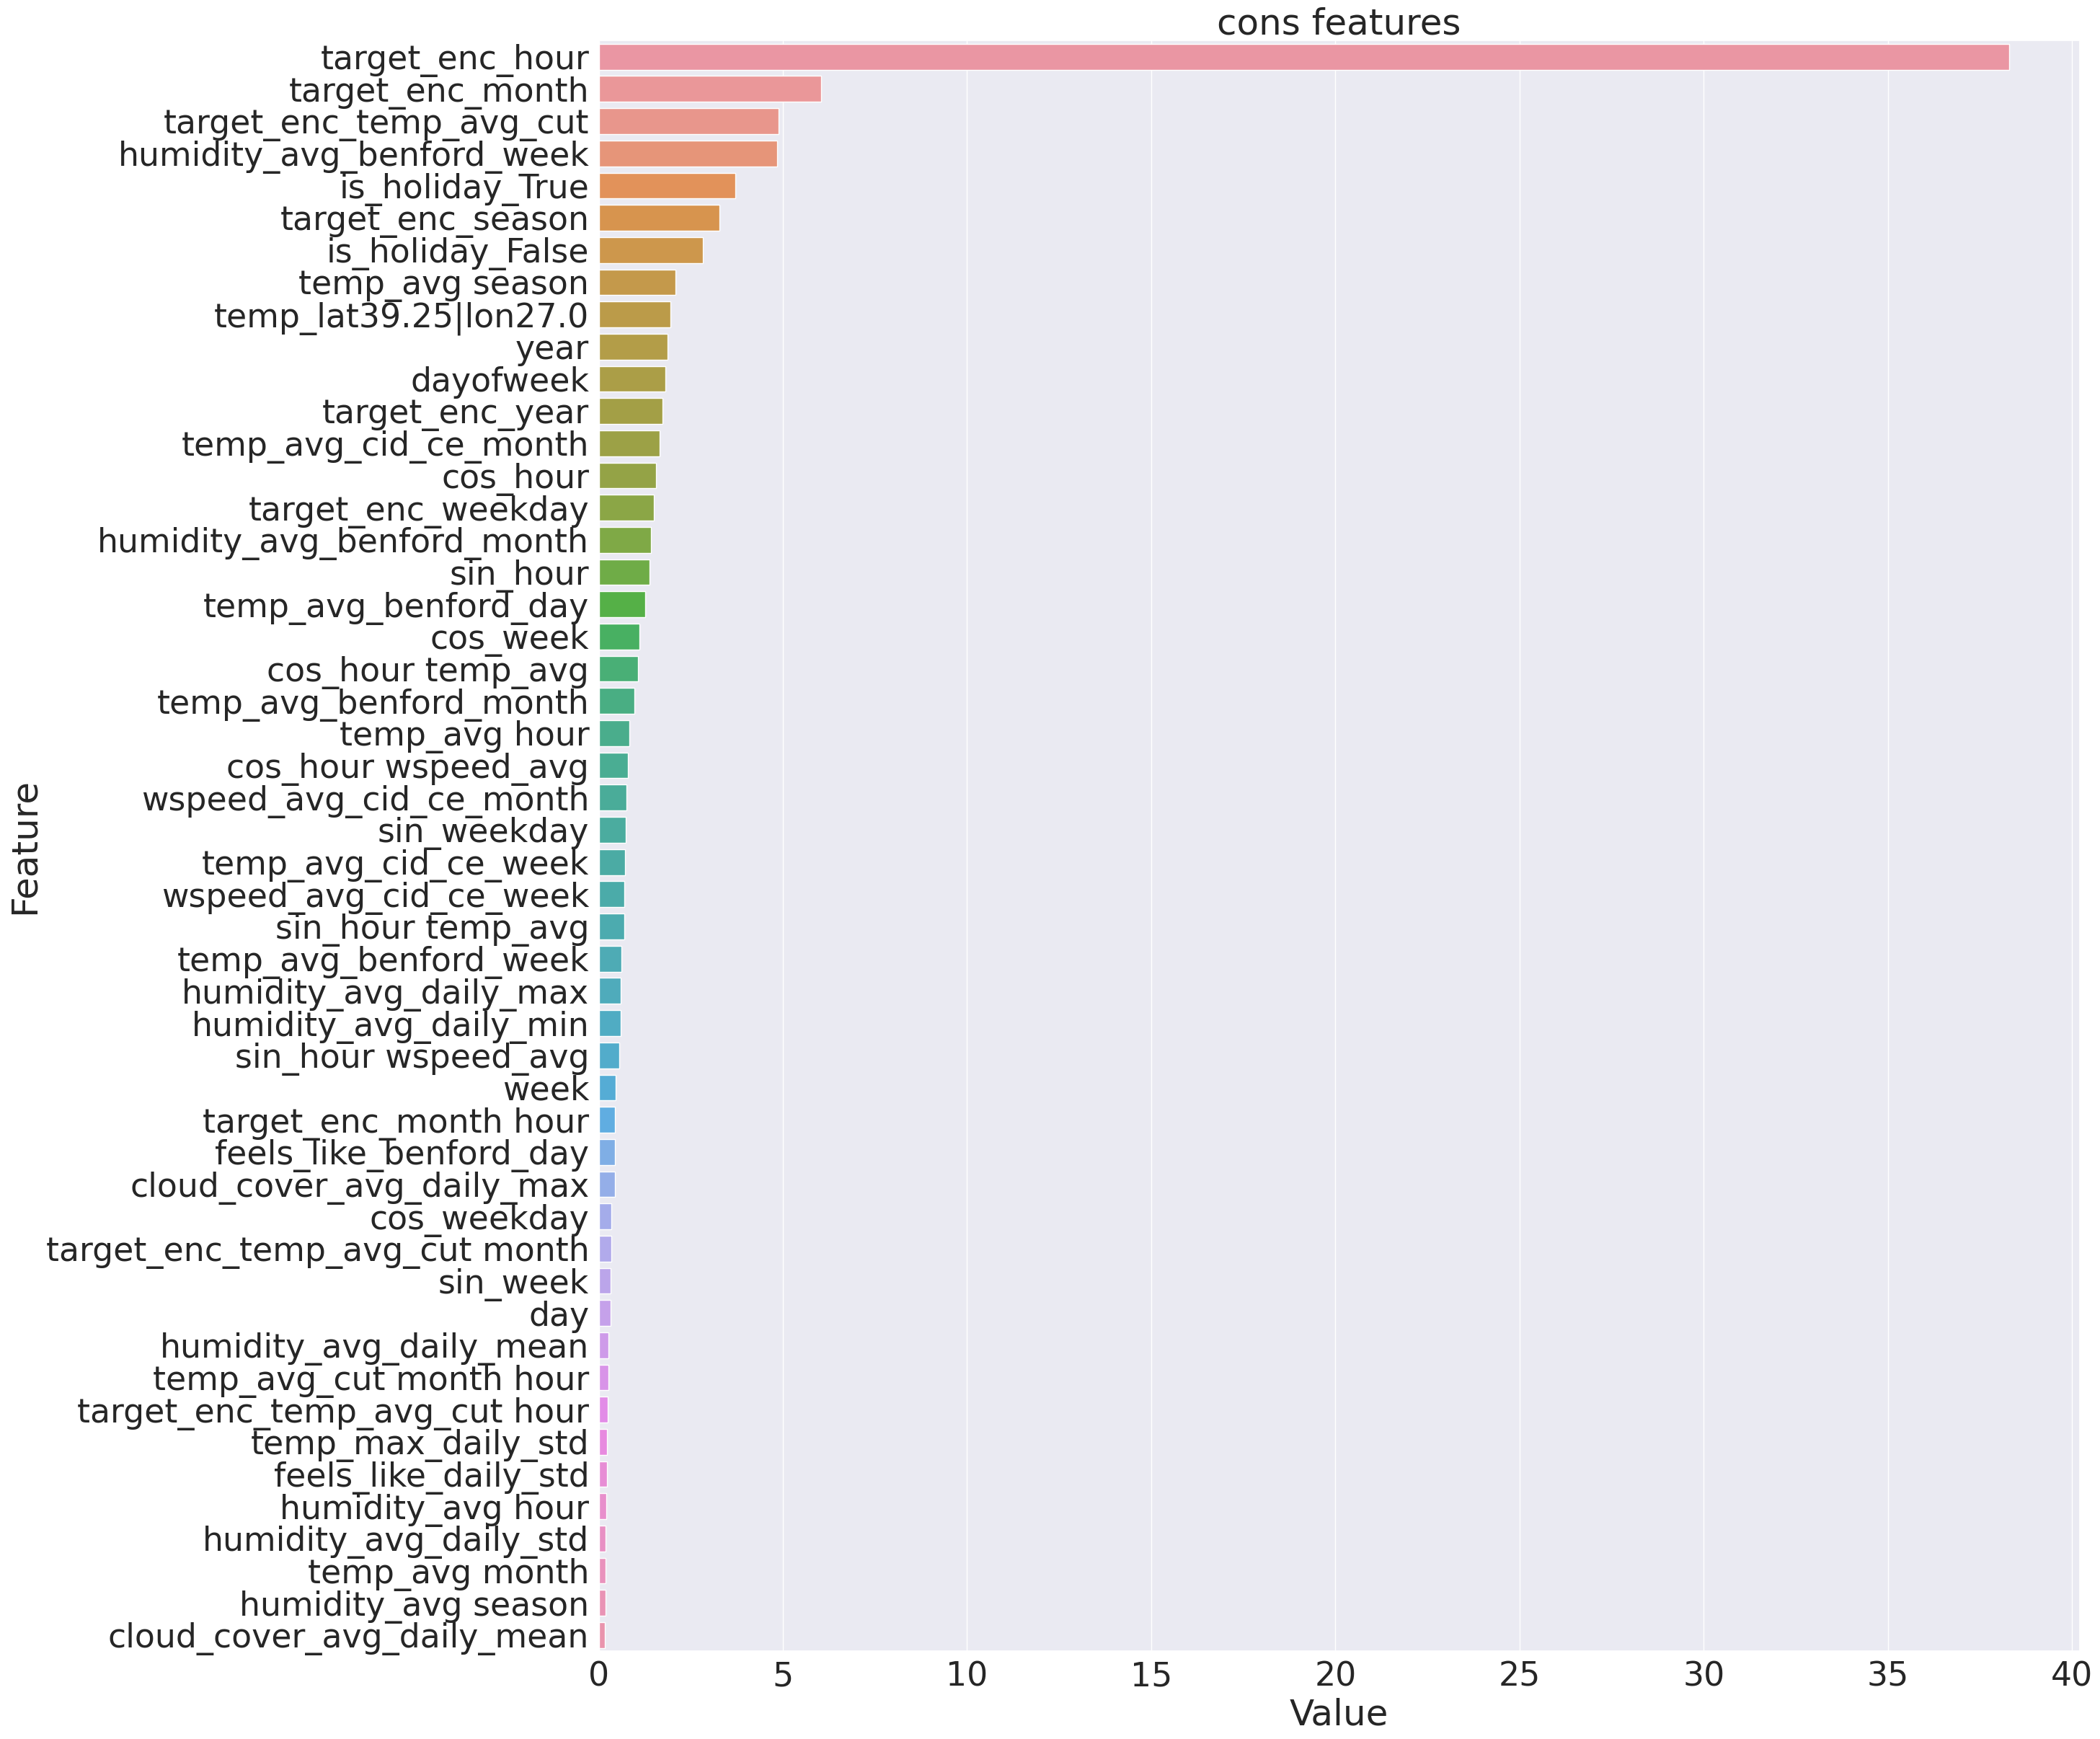

In [26]:
most_n_feats = 50
 
feature_imp = pd.DataFrame({'Value':model.get_feature_importance(),'Feature':training_df[model_cols].columns})

plt.figure(figsize=(30, 25))
sns.set(font_scale = 3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                        ascending=False)[0:most_n_feats])
plt.title('{} features'.format('cons'))
plt.tight_layout()

**Unseen Prediction**

In [27]:
models = []

for i in [42, 1337, 2716, 1122, 4455]:
    default_params["random_seed"] = i
    
    model = CatBoostRegressor(**default_params)
    model = model.fit(training_df[model_cols], training_df['cons'].values)
    models.append(model)
#    
preds = [model.predict(unseen_df[model_cols]) for model in models]
mean_preds = np.mean(preds, axis=0)
#
unseen_pred_df['pred'] = mean_preds

In [28]:
fig =  go.Figure()
tmp_unseen = unseen_pred_df.sort_index().copy()

fig.add_trace(go.Scatter(x=tmp_unseen.index, y=tmp_unseen['pred'],
                        mode='lines',
                        name='tahmin',
                        line_shape='spline',
                        line=dict( width=3))) 

fig.show()

**Submission File**

In [ ]:
sub_df.loc[:,'Dağıtılan Enerji (MWh)'] = unseen_pred_df.pred.values
sub_df.to_csv('submission_file/submission.csv', index=False)